In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import graph_policy

In [3]:
from graph_policy import clauses_to_matrix
from cnf import get_random_kcnfs, CNF

In [4]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
META_FILE = "models/activepolicy-18-04-02-015404/model-8797184.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/activepolicy-18-04-02-015404/model-8797184


In [5]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [6]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [7]:
LEVEL = 10

In [8]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [9]:
np.set_printoptions(precision=3, suppress=True)

In [10]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")
#import sys
#logfile = sys.stdout

class EpsSearch():
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        #print("CNF:", input_cnf, end=' ', file=logfile)
        #print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        #print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        svars = []
        probs = []
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svars.append(svar)
                raw_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                probs.append(raw_prob**3)
        prob_sum = sum(probs)
        probs = [prob/prob_sum for prob in probs]
        best_svar = np.random.choice(svars, 1, p=probs)[0]
        
        #print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def one_find(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        sug_var = self.suggest(cnf)
        sug_cnf = cnf.set_var(sug_var)

        sug_res = self.one_find(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        return None
    
    def repeat_find(self, cnf: CNF, max_tries=100):
        for error_count in range(max_tries):
            res = self.one_find(cnf)
            if res is None:
                continue
            return res, error_count
        raise ValueError('sat not found')

In [11]:
import pycosat

In [12]:
import time
from functools import wraps
def measured(func):
    @wraps(func)
    def new_func(*args, **kwargs):
        start = time.time()
        results = func(*args, **kwargs)
        end = time.time()
        return results, (end - start)
    return new_func

In [13]:
@measured
def solve_graph(cnf: CNF):
    epss = EpsSearch()
    res, errors = epss.repeat_find(cnf)
    return res, errors

@measured
def solve_pyco(cnf: CNF):
    return pycosat.solve(cnf.clauses)

In [14]:
from numpy import mean

In [15]:
def get_avg_stats(cnfs):
    times = []
    timesp = []
    errors = []
    sat_count = 0
    for cnf in cnfs:
        resp, timp = solve_pyco(cnf)
        if resp == 'UNSAT':
            continue
        (resg, error_count), timg = solve_graph(cnf)
        #print(timp, timg/BATCH_SIZE, 'UNSAT' if resp == 'UNSAT' else 'SAT')
        times.append(timg)
        timesp.append(timp)
        errors.append(error_count)
        sat_count += 1
    return mean(times), mean(timesp), mean(errors), sat_count

def get_avg_stats_for(var_num, clause_num, sample=100):
    cnfs = get_random_kcnfs(sample, 3, var_num, clause_num, min_clause_number=clause_num)
    return get_avg_stats(cnfs)

In [16]:
def get_avg_stats_for_range(var_nums, clause_nums, sample=5):
    times = []
    timesp = []
    errors = []
    sat_counts = []
    for var_num, clause_num in zip(var_nums, clause_nums):
        print("Computing {}, {}, ".format(var_num, clause_num), end="")
        tim, timp, error_count, sat_count = get_avg_stats_for(var_num, clause_num, sample)
        print(tim*sample)
        times.append(tim)
        timesp.append(timp)
        errors.append(error_count)
        sat_counts.append(sat_count)
    return times, timesp, errors, sat_counts

In [17]:
def plot_avg_stats_for_range(var_nums, clause_nums, sample=5, versus=None):
    times, timesp, errors, sat_counts = get_avg_stats_for_range(var_nums, clause_nums, sample)
    plt.figure(figsize=(13.5, 4))
    plt.subplot(1, 2, 1)
    plt.title("Times vs {}".format(versus))
    plt.plot(times, label='graph')
    plt.plot(timesp, label='pycosat')
    plt.yscale('log')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot([tg/tp for (tg, tp) in zip(times, timesp)], label='graph/pycosat')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    plt.title("Error count vs {}".format(versus))
    plt.plot(errors)
    plt.show()
    
    plt.title("Sat count vs {}".format(versus))
    plt.plot(sat_counts)
    plt.show()

Computing 3, 0, 3.8623809814453125e-05
Computing 3, 1, 1.0835120677947998
Computing 3, 2, 0.12273550033569336
Computing 3, 3, 0.1487421989440918
Computing 3, 4, 0.166701078414917
Computing 3, 5, 0.1353311538696289
Computing 3, 6, 0.13100123405456543
Computing 3, 7, 0.14634299278259277
Computing 3, 8, 0.14847874641418457
Computing 3, 9, 0.18933510780334473
Computing 3, 10, 0.20555806159973145
Computing 3, 11, 0.25741391711764866
Computing 3, 12, 0.16848087310791016
Computing 3, 13, 0.19659900665283203
Computing 3, 14, 0.19918441772460938
Computing 3, 15, 0.1824977993965149
Computing 3, 16, 0.1620417833328247
Computing 3, 17, 0.1636859348842076
Computing 3, 18, 0.18736600875854492
Computing 3, 19, nan


/home/jaszczur/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaszczur/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaszczur/.local/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


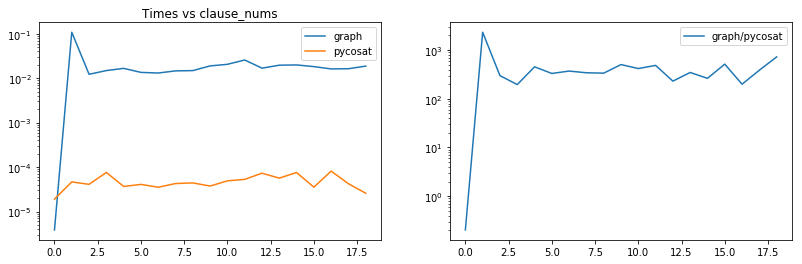

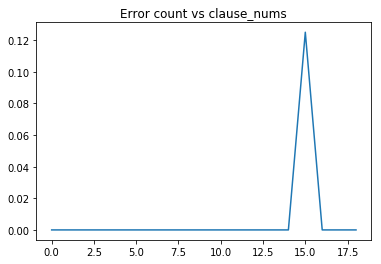

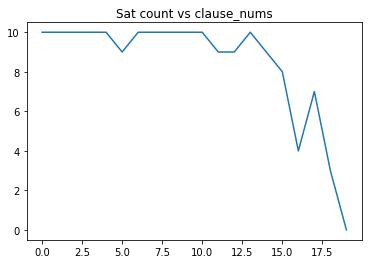

In [18]:
RANGE = 30
plot_avg_stats_for_range([3]*RANGE, range(20), sample=10, versus="clause_nums")

Computing 0, 0, 1.3828277587890625e-05
Computing 1, 4, 0.049059391021728516
Computing 2, 8, 0.05978083610534668
Computing 3, 12, 0.09458470344543457
Computing 4, 16, 0.1152960459391276
Computing 5, 20, 0.13843870162963867
Computing 6, 24, 0.23847436904907227
Computing 7, 28, 0.25592637062072754
Computing 8, 32, 0.42496164639790857
Computing 9, 36, 0.548740029335022
Computing 10, 40, 0.4685049057006836
Computing 11, 44, 0.4403571287790934
Computing 12, 48, 0.4971754550933838
Computing 13, 52, 0.771220326423645
Computing 14, 56, 0.6851762533187866
Computing 15, 60, 0.7745047410329182
Computing 16, 64, 0.9429678916931152
Computing 17, 68, 0.8687227964401245
Computing 18, 72, 0.9399634599685669
Computing 19, 76, 1.8449026346206665
Computing 20, 80, 1.1959651112556458
Computing 21, 84, 3.1066110730171204
Computing 22, 88, 2.4720568656921387
Computing 23, 92, 3.0011919140815735
Computing 24, 96, 2.4608245491981506
Computing 25, 100, 3.3427613973617554
Computing 26, 104, 10.581910133361816
Co

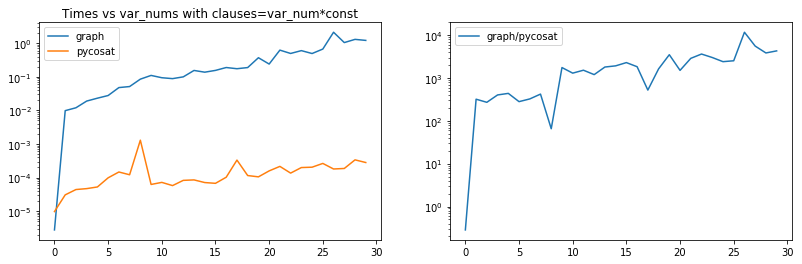

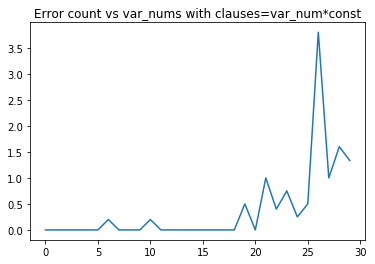

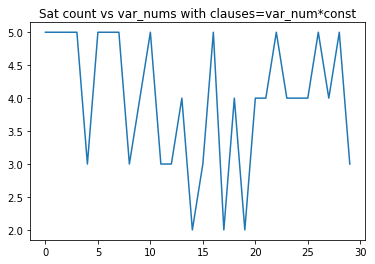

In [19]:
VAR_NUMS = range(30)
CLAUSE_NUMS = [int(var_num*4.0) for var_num in VAR_NUMS]
plot_avg_stats_for_range(VAR_NUMS, CLAUSE_NUMS, sample=5, versus="var_nums with clauses=var_num*const")

Computing 0, 0, 1.5974044799804688e-05
Computing 1, 4, 0.03574967384338379
Computing 2, 8, 0.046524107456207275
Computing 3, 12, 0.07254552841186523
Computing 4, 16, 0.19239068031311035
Computing 5, 20, 0.1872009038925171
Computing 6, 24, 0.2873361110687256
Computing 7, 28, 0.3318047523498535
Computing 8, 32, 0.5331993103027344
Computing 9, 36, 0.3656407197316488
Computing 10, 40, 0.4829213619232178
Computing 11, 44, 0.5008443196614584
Computing 12, 48, 1.2927663326263428
Computing 13, 52, 0.8873569965362549
Computing 14, 56, 0.8289909362792969
Computing 15, 60, 0.92000812292099
Computing 16, 64, 1.094934344291687
Computing 17, 68, 1.0575485229492188
Computing 18, 72, 1.6379547119140625
Computing 19, 76, 1.6472309827804565
Computing 20, 80, 1.4742541313171387
Computing 21, 84, 2.321631908416748
Computing 22, 88, 1.8303143978118896
Computing 23, 92, 1.9551150798797607
Computing 24, 96, 2.216440439224243
Computing 25, 100, 3.1346380710601807
Computing 26, 104, 14.244882822036743
Computin

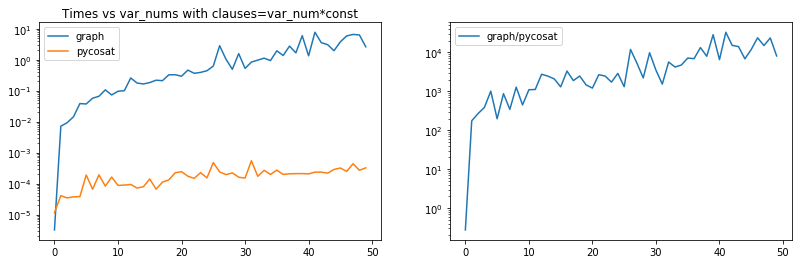

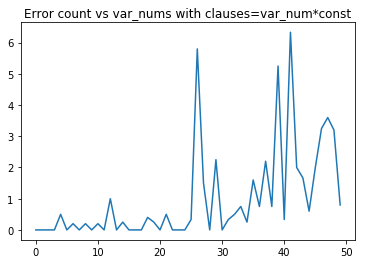

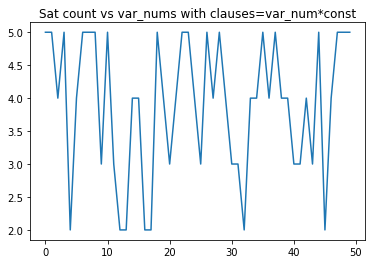

In [20]:
VAR_NUMS = range(50)
CLAUSE_NUMS = [int(var_num*4.0) for var_num in VAR_NUMS]
plot_avg_stats_for_range(VAR_NUMS, CLAUSE_NUMS, sample=5, versus="var_nums with clauses=var_num*const")

In [21]:
VAR_NUMS = range(100)
CLAUSE_NUMS = [int(var_num*4.0) for var_num in VAR_NUMS]
plot_avg_stats_for_range(VAR_NUMS, CLAUSE_NUMS, sample=5, versus="var_nums with clauses=var_num*const")

Computing 0, 0, 2.288818359375e-05
Computing 1, 4, 0.033708413441975914
Computing 2, 8, 0.03823310136795044
Computing 3, 12, 0.06440496444702148
Computing 4, 16, 0.12825965881347656
Computing 5, 20, 0.23134469985961914
Computing 6, 24, 0.1749996344248454
Computing 7, 28, 0.2764129638671875
Computing 8, 32, 0.3799086809158325
Computing 9, 36, 0.4100325107574463
Computing 10, 40, 0.4440859953562418
Computing 11, 44, 0.49298810958862305
Computing 12, 48, 0.4892429709434509
Computing 13, 52, 0.6433351039886475
Computing 14, 56, 1.0480093955993652
Computing 15, 60, 0.7222692966461182
Computing 16, 64, 1.000291109085083
Computing 17, 68, 0.923835039138794
Computing 18, 72, 1.2074223160743713
Computing 19, 76, 2.386024236679077
Computing 20, 80, 1.1022226015726726
Computing 21, 84, 2.0800180435180664
Computing 22, 88, 2.968350350856781
Computing 23, 92, 1.3858389854431152
Computing 24, 96, 2.436793645222982
Computing 25, 100, 5.0044190883636475
Computing 26, 104, 2.2818970680236816
Computing 

ValueError: sat not found